In [19]:
import random
import numpy as np
import pandas as pd
import collections as cl
from matplotlib import pyplot as plt
import logomaker
import scipy

## Setting GROUPS

In [2]:
## NEGATIVE CONTROL

atg_list = []

with open("./nosdtemp.fasta", mode="r") as fasta:
    for line in fasta:
        seq_lines = []
        while not (line.startswith(">") or line == ""):
            seq_lines.append(line.strip())
            line = fasta.readline()
        if seq_lines != []:
            seq = "".join(seq_lines).replace("-", "")
            for i in range(len(seq))[11:-3]:
                if seq[i:i+3] == "atg":
                    atg_list.append(seq[i-11:i+3])

random.seed(42)                   
Negative_control = random.sample(atg_list, 2602)
print(len(Negative_control))

2602


In [3]:
## TRAINING GROUP

with open("./ecoli_sd_train.fasta", mode="r") as fasta:
    Training_group = [elem.strip() for elem in fasta.readlines() if not elem.startswith(">")]

## TEST GROUP

with open("./ecoli_sd_test.fasta", mode="r") as fasta:
    Test_group = [elem.strip() for elem in fasta.readlines() if not elem.startswith(">")]

print(len(Training_group), len(Test_group))

1735 2602


## Building a PWM

In [4]:
template = pd.DataFrame(0, index=["a", "t", "g", "c"], columns=list(range(15))[1:], dtype=float)

Nbj = template.copy()
cols = list(zip(*Training_group))
cols = map(cl.Counter, list(zip(*Training_group)))
cols = list(cols)
for i in range(len(cols) + 1)[1:]:
    Nbj[i] = cols[i - 1]

# n_nuc = n_nuc
N_sum = len(Training_group)
pseudo = 0.1

fbj = (Nbj.copy() / N_sum)
Fbj = ((Nbj.copy() + pseudo) / (N_sum + 4*pseudo))

Wbj = template.copy()
Wbj.loc[["a", "t"], :] = np.log(Fbj.copy().loc[["a", "t"], :] / 0.2475)
Wbj.loc[["g", "c"], :] = np.log(Fbj.copy().loc[["g", "c"], :] / 0.2525)

Wbj.round(2)

1     2     3     4     5     6     7     8     9     10    11    12  \
a  0.44  0.23  0.20  0.33  0.40  0.28  0.28  0.41  0.53  0.06  0.11  1.28   
t -0.76 -0.72 -0.93 -0.63 -0.27  0.03  0.10  0.03 -0.30  0.30  0.22 -2.59   
g  0.44  0.68  0.77  0.58  0.29  0.09 -0.13 -0.39 -0.14 -0.63 -0.48 -1.07   
c -0.85 -1.29 -1.52 -1.25 -0.88 -0.57 -0.36 -0.24 -0.36  0.06  0.02 -5.34   

     13    14  
a -4.43 -4.93  
t  1.39 -4.25  
g -4.67  1.37  
c -5.99 -4.45

In [5]:
print(Wbj.round(2).to_html())

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>1</th>
      <th>2</th>
      <th>3</th>
      <th>4</th>
      <th>5</th>
      <th>6</th>
      <th>7</th>
      <th>8</th>
      <th>9</th>
      <th>10</th>
      <th>11</th>
      <th>12</th>
      <th>13</th>
      <th>14</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>a</th>
      <td>0.44</td>
      <td>0.23</td>
      <td>0.20</td>
      <td>0.33</td>
      <td>0.40</td>
      <td>0.28</td>
      <td>0.28</td>
      <td>0.41</td>
      <td>0.53</td>
      <td>0.06</td>
      <td>0.11</td>
      <td>1.28</td>
      <td>-4.43</td>
      <td>-4.93</td>
    </tr>
    <tr>
      <th>t</th>
      <td>-0.76</td>
      <td>-0.72</td>
      <td>-0.93</td>
      <td>-0.63</td>
      <td>-0.27</td>
      <td>0.03</td>
      <td>0.10</td>
      <td>0.03</td>
      <td>-0.30</td>
      <td>0.30</td>
      <td>0.22</td>
      <td>-2.59</td>
      <td>1.39</td>
      <td>-4.25<

## Building an IC MATRIX

In [6]:
wbj = template.copy()
wbj.loc[["a", "t"], :] = np.log2(fbj.copy().loc[["a", "t"], :] / 0.2475)
wbj.loc[["g", "c"], :] = np.log2(fbj.copy().loc[["g", "c"], :] / 0.2525)

ICbj = fbj.copy() * wbj.copy()
ICbj.loc["IC(j)", :] = ICbj.sum(axis=0)

ICbj.round(2)

1     2     3     4     5     6     7     8     9     10    11    12  \
a      0.24  0.11  0.09  0.17  0.21  0.13  0.13  0.22  0.32  0.02  0.04  1.66   
t     -0.13 -0.12 -0.13 -0.12 -0.07  0.01  0.04  0.01 -0.08  0.14  0.10 -0.07   
g      0.25  0.48  0.60  0.37  0.14  0.03 -0.04 -0.10 -0.04 -0.12 -0.11 -0.13   
c     -0.13 -0.13 -0.12 -0.13 -0.13 -0.12 -0.09 -0.07 -0.09  0.02  0.01 -0.01   
IC(j)  0.23  0.34  0.44  0.29  0.15  0.06  0.04  0.07  0.11  0.07  0.04  1.44   

         13    14  
a     -0.02 -0.01  
t      1.99 -0.02  
g     -0.02  1.96  
c     -0.01 -0.02  
IC(j)  1.96  1.91

In [7]:
print(ICbj.round(2).to_html())

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>1</th>
      <th>2</th>
      <th>3</th>
      <th>4</th>
      <th>5</th>
      <th>6</th>
      <th>7</th>
      <th>8</th>
      <th>9</th>
      <th>10</th>
      <th>11</th>
      <th>12</th>
      <th>13</th>
      <th>14</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>a</th>
      <td>0.24</td>
      <td>0.11</td>
      <td>0.09</td>
      <td>0.17</td>
      <td>0.21</td>
      <td>0.13</td>
      <td>0.13</td>
      <td>0.22</td>
      <td>0.32</td>
      <td>0.02</td>
      <td>0.04</td>
      <td>1.66</td>
      <td>-0.02</td>
      <td>-0.01</td>
    </tr>
    <tr>
      <th>t</th>
      <td>-0.13</td>
      <td>-0.12</td>
      <td>-0.13</td>
      <td>-0.12</td>
      <td>-0.07</td>
      <td>0.01</td>
      <td>0.04</td>
      <td>0.01</td>
      <td>-0.08</td>
      <td>0.14</td>
      <td>0.10</td>
      <td>-0.07</td>
      <td>1.99</td>
      <td>-0.02<

## Running the TESTS

In [8]:
def calc_weights(seqs, matrix):
    w_list = []
    for seq in seqs:
        w = 0
        for i in range(len(seq)):
            w += matrix.at[seq[i], i+1]
        w_list.append(w)
    return w_list

Training_group_w = calc_weights(Training_group, Wbj)
Test_group_w = calc_weights(Test_group, Wbj)
Negative_control_w = calc_weights(Negative_control, Wbj)

In [10]:
thr = 4

print("Training_group")
print("Total:", len(Training_group_w))
print("True:", len([i for i in Training_group_w if i >= thr]))

print("Test_group_w")
print("Total:", len(Test_group_w))
print("True:", len([i for i in Test_group_w if i >= thr]))

print("Negative_control_w")
print("Total:", len(Negative_control_w))
print("True:", len([i for i in Negative_control_w if i >= thr]))

Training_group
Total: 1735
True: 1300
Test_group_w
Total: 2602
True: 1935
Negative_control_w
Total: 2602
True: 492


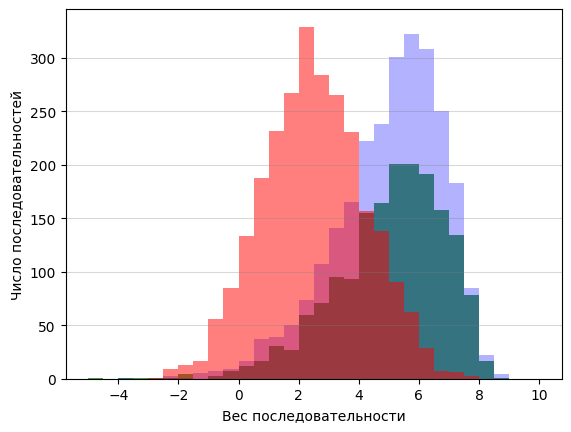

In [16]:
bin_list = [-5 + n*0.5 for n in range(31)]

plt.hist(Training_group_w, bin_list,
         color="green",
         alpha=0.7)

plt.hist(Test_group_w, bin_list,
         color="blue",
         alpha=0.3)

plt.hist(Negative_control_w, bin_list,
         color="red",
         alpha=0.5)

plt.grid(which="major", axis="y", color="grey", alpha=0.3)
plt.xlabel("Вес последовательности")
plt.ylabel("Число последовательностей")

plt.show()

## Creating a LOGO

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\logomaker\src\matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


Text(0, 0.5, 'Information Content (bits)')

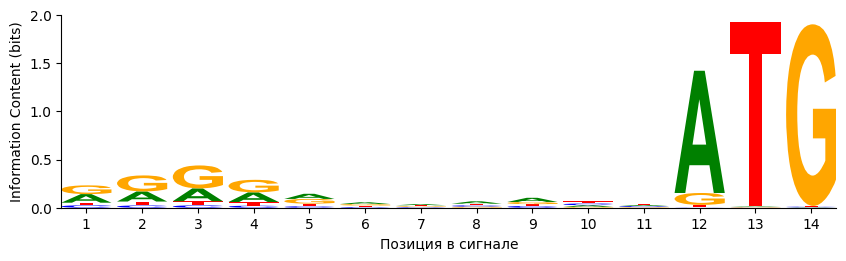

In [17]:
signal_list = list(map(lambda x: x.upper(), Training_group))

signal_df = logomaker.alignment_to_matrix(signal_list, to_type="information")

signal_logo = logomaker.Logo(signal_df,
                            color_scheme="classic",
                            font_name="Arial",
                            width=0.9)

signal_logo.style_spines(spines=["top", "right"], visible=False,)

signal_logo.ax.set_xticks(list(range(14)))
signal_logo.ax.set_xticklabels(list(range(15)[1:]))
signal_logo.ax.set_yticks([0.0, 0.5, 1.0, 1.5, 2.0])

signal_logo.ax.set_xlabel("Позиция в сигнале")
signal_logo.ax.set_ylabel("Information Content (bits)")

## P-VALUE

In [22]:
scipy.stats.norm.cdf(-13.94)

1.8097010772039175e-44